# Environment basics

This notebook explores the foundation of the environment side of the reinforcement learning problem.

The main question we are trying to solve in the end is the following: *How should an agent act?*

### The environment
The only thing we have is an environment in which we can act. We can (often only partially) observe the state of the environment: $s_t$.
Based on $s_t$, we can choose which action $a_t$ to perform. As a result of this state-action combination, we get a reward $r_t = R(s_t, a_t)$.

Let's keep close to the code while exploring these ideas!

Let's start by:
1. Making an environment.
2. Take a look at what an observation looks like.
3. See what an action looks like.
4. See what a reward looks like.

*(Note: we use gymnasium, the most used package for running reinforcement learning environments, originally developed by OpenAI)*

In [44]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [68]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

observation, _ = env.reset(seed=13)

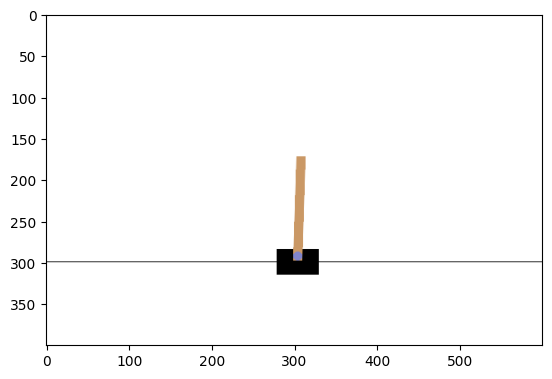

In [69]:
plt.imshow(env.render())

In [70]:
print("Observation:", observation)

Observation: [ 0.03647976  0.03553025  0.03110234 -0.02385536]


We can see that our 'observation', closely related to the state $s_t$ of the environment, is given as 4 numbers. Also note how this is not the same as the 'rendering' of our environment. We can render our environment using this observation, because the problem was engineered as such. The 4 variables mean the following (this can be found in the docs of `gymnasium`:

| Position | Description | Min | Max |
| --- | --- | --- | --- |
| 0 | Cart position | -4.8 | 4.8 |
| 1 | Cart velocity | -inf | inf |
| 2 | Pole angle | -0.418 rad (-24°) | 0.418 rad (24°) |
| 3 | Pole Angular Velocity | -inf | inf |

Okay, so we have four numbers on which we now can base an action. How we do this will later be called our 'policy', but for now let's just explore the possible actions.

In [71]:
env.action_space

Discrete(2)

As can be seen, our 'action space', i.e. the space of all possible actions, is in this case very simple and we have two discrete actions. Because there are only 2 possibilities, this is represented as a single element which is 0 or 1. 0 means push the cart to the left, 1 means push the cart to the right.

So let's put this to the test. Right now the cart position is:

In [72]:
print("Cart position now:", observation[0])

Cart position now: 0.03647976


Now let's push the cart to the right:

In [73]:
action = 1
new_observation, _, _, _, _ = env.step(action)
print("New cart position:", new_observation[0])

New cart position: 0.037190363


As we can see, the cart position is pushed to the right (it's position increased).

Now let's inspect the reward for this specific environment. How an agent receives rewards differs per environment and the task the agent should complete. Let's inspect it for this case. A reward is given every time the agent takes an action (although the reward may be 0, when there is no explicit reward for that timestep/state).

In [74]:
new_observation, reward, _, _, _ = env.step(1)
print("Reward:", reward)

Reward: 1.0


In this case we get a reward of 1. In this particular environment, the goals is to keep the pole up for as long as possible. If the pole falls down, the trajectory is stopped, and the return for that trajectory becomes smaller. So, given a reward for every timestep the agent 'survives', is equivalent to saying 'you should keep going on as long as possible. 

### Trajectory

When we repeat the cycle of 'state -> action -> reward' many times, we get what we call a trajectory $\tau$, which is simply a set of state, action, reward tuples, i.e. $(s_t, a_t, r_t)$. How long a trajectory is, or when it ends, depends on the problem you are trying to solve. I.e. some tasks end after some particular state is reached, and hence trajectories are of a fixed, but varying length. Some problems do not have a natural 'stop' of the episode, for example controlling the temperature of a room never ends (in such a case you usually cut off a trajectory at a fixed number of timesteps).

How do we know how well an agent has 'performed' in a trajectory? Given that for every action the agent has received a reward, the simplest thing is to say that this is measured by the sum of all individual rewards: $\sum_{t=0}^T r_t$. This is oftend called the 'return' of a trajectory. The higher this return, the 'better' the agent has done.

So our question becomes: *How should an agent act in order to maximize its return?*.

Let's combine this with code.

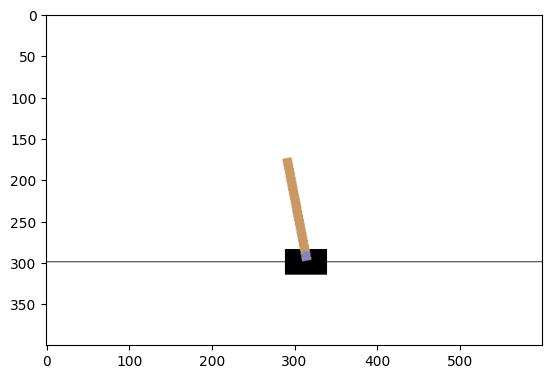

In [89]:
observation, info = env.reset()
img = plt.imshow(env.render())

observations = []
actions = []
rewards = []

done = False
while not done:
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = env.action_space.sample()
    new_observation, reward, terminated, truncated, info = env.step(action)

    observations.append(observation)
    actions.append(action)
    rewards.append(reward)

    observation = new_observation
    done = terminated or truncated

This code has runned a complete 'trajectory', sometimes also called an 'episode'. The actions taken in this trajectory were random, so results might differ on other runs, but in this csae our trajectory had the following properties:

In [98]:
print("Number of steps:", len(observations))
print("Number of actions (should be same):", len(actions))
print("Number of times pushed to the left:", (np.array(actions) == 0).sum())
print("Number of times pushed to the right:", (np.array(actions) == 1).sum())

print("\nReturn (sum of rewards):", np.sum(rewards))

Number of steps: 39
Number of actions (should be same): 39
Number of times pushed to the left: 19
Number of times pushed to the right: 20

Return (sum of rewards): 39.0


### Creating our own policy

So far, we have interacted with the environment in a random way. In the end, we want an agent to learn this automatically from observations, but to get a feeling it is good to think about it for ourselves first.

My first guess would be that the pole angle is very important in deciding whether or not to push left or right. When the pole is leaning to the left, we should also push to the left (to invert the movement), and vice versa.

So lets implement a simple policy that does this and see how it does in the environment.

In [99]:
def cartpole_policy(observation):
    """ Simple policy that pushes to the left when the pole leans to the left, else pushes right. """
    pole_angle = observation[2]
    if pole_angle < 0:
        return 0

    return 1

Terminated: True
Truncated: False


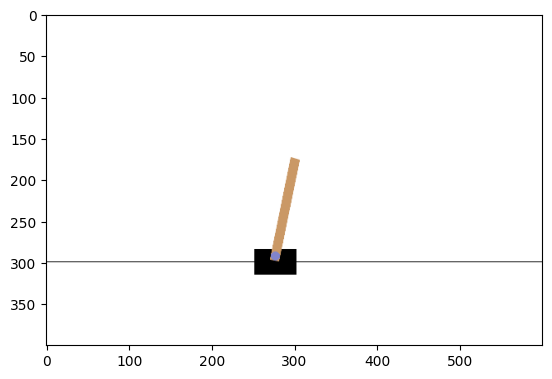

In [101]:
observation, info = env.reset()
img = plt.imshow(env.render())

done = False
while not done:
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    action = cartpole_policy(observation)
    observation, reward, terminated, truncated, info = env.step(action)

    done = terminated or truncated

print("Terminated:", terminated)
print("Truncated:", truncated)

When looking at the video (for this you have to run the notebook), you can see that it already makes sense, but it spins out of control.

In order to fix this, we could start looking at the angular velocity. We will not do that now but one can imagine that good control takes into account most or all variables from the observation.

### Next steps

Knowing the basics of how to interact with the environment is important. Next we can take a look into the basics of learning a policy.